In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import os
from torchvision.models import regnet_x_3_2gf, RegNet_X_3_2GF_Weights

In [2]:
image_shapes = []

for image in os.listdir("../Data/images"):
    img = cv.imread("../Data/images/"+image)
    image_shapes.append(img.shape)

In [3]:
max(image_shapes), min(image_shapes)

((4757, 5623, 3), (156, 157, 3))

In [4]:
len(np.unique(image_shapes))

801

In [5]:
weights = RegNet_X_3_2GF_Weights.IMAGENET1K_V2
model = regnet_x_3_2gf(weights=weights)
preprocess = weights.transforms()

In [63]:
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [79]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((232,232)),
    torchvision.transforms.CenterCrop((224,224)),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

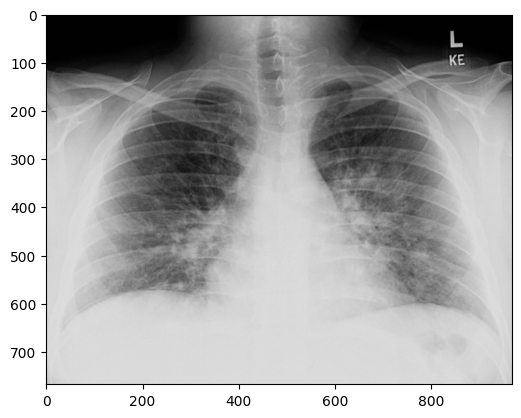

In [91]:
img = Image.open("../Data/images/000001-1.jpg")
plt.imshow(img)

In [67]:
t = torchvision.transforms.ToTensor()
img = t(img)

In [90]:
img = np.array(img)
img.shape

(768, 968, 4)

In [92]:
img = img.convert("RGB")
a = transform(img)

C:\Users\Prash\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [93]:
a.shape

torch.Size([3, 224, 224])

In [73]:
a = np.array(a)

In [75]:
a = a.reshape((224,224,3))

In [7]:
import pandas as pd

data = pd.read_csv("../Data/processed_metadata.csv")

In [8]:
torch.tensor(data.loc[0, ['sex', 'age', 'survival']].tolist())

tensor([ 0., 65.,  1.], dtype=torch.float64)

In [9]:
type(data.loc[0, ['sex', 'age', 'survival']].tolist()[1])

numpy.float64

In [10]:
data.columns

Index(['Unnamed: 0', 'sex', 'age', 'RT_PCR_positive', 'survival', 'intubated',
       'intubation_present', 'went_icu', 'in_icu', 'view_AP', 'view_AP Erect',
       'view_AP Supine', 'view_Axial', 'view_Coronal', 'view_L', 'view_PA',
       'modality', 'filename', 'Aspergillosis', 'Aspiration', 'Bacterial',
       'COVID-19', 'Chlamydophila', 'E.Coli', 'Fungal', 'H1N1', 'Herpes ',
       'Influenza', 'Klebsiella', 'Legionella', 'Lipoid', 'MERS-CoV', 'MRSA',
       'Mycoplasma', 'No Finding', 'Nocardia', 'Pneumocystis', 'Pneumonia',
       'SARS', 'Staphylococcus', 'Streptococcus', 'Tuberculosis', 'Unknown',
       'Varicella', 'Viral', 'todo', 'offset_standardized'],
      dtype='object')

In [30]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset_CSVlabels(Dataset):
    """
    A PyTorch dataset for loading spectrogram images and their corresponding labels from a CSV file.

    Args:
        csv_file (str): Path to the CSV file containing the image file names and labels.
        img_dir (str): Root directory where the image files are stored.
        transform (callable, optional): A function/transform that takes in a PIL image and returns a transformed version. 
            E.g, ``transforms.RandomCrop`` for randomly cropping an image.

    Attributes:
        img_labels (DataFrame): A pandas dataframe containing the image file names and labels.
        img_dir (str): Root directory where the image files are stored.
        transform (callable, optional): A function/transform that takes in a PIL image and returns a transformed version. 
            E.g, ``transforms.RandomCrop`` for randomly cropping an image.
    
    Methods:
        __len__(): Returns the length of the dataset.
        __getitem__(index): Returns the image and label at the given index.

    Returns:
        A PyTorch dataset object that can be passed to a DataLoader for batch processing.
    """
    def __init__(self,csv_file, img_dir, filename_column, label_column, transform=None) -> None:
        super().__init__()
        self.img_labels = pd.read_csv(csv_file)
        self.img_labels.drop(['Unnamed: 0'], axis=1, inplace=True)
        self.img_dir = img_dir
        self.transform = transform
        self.filename = filename_column
        self.label = label_column

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.img_labels)
    
    def __getitem__(self, index):
        """
        Returns the image and label at the given index.

        Args:
            index (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image and label.
        """
        img_path = os.path.join(self.img_dir, self.img_labels.loc[index,self.filename])
        image = Image.open(img_path)
        image = image.convert("RGB")
        y_label = torch.tensor(self.img_labels.loc[index, self.label])

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [42]:
dataset = CustomDataset_CSVlabels("../Data/processed_metadata.csv", "../Data/images", "filename", ['Aspergillosis', 'Aspiration', 'Bacterial', 'COVID-19', 'Chlamydophila', 'E.Coli', 'Fungal', 'H1N1', 'Herpes ', 'Influenza', 'Klebsiella', 'Legionella', 'Lipoid', 'MERS-CoV', 'MRSA', 'Mycoplasma', 'No Finding', 'Nocardia', 'Pneumocystis', 'Pneumonia', 'SARS', 'Staphylococcus', 'Streptococcus', 'Tuberculosis', 'Unknown', 'Varicella', 'Viral', 'todo'], transform=preprocess)

In [43]:
a = dataset.__getitem__(0)

C:\Users\Prash\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [44]:
a[0].shape

torch.Size([3, 224, 224])

In [45]:
from torch.utils.data import DataLoader

In [46]:
total_data = len(dataset)
train_size = int(0.7 * total_data)
val_size = int(0.15 * total_data)
test_size = total_data - train_size - val_size

In [47]:
from torch.utils.data import random_split

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [58]:
class Model_BN(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model_branch = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=1),
            torch.nn.SELU(),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.SELU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            torch.nn.SELU(),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.SELU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Dropout2d(p=0.3),
            torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            torch.nn.SELU(),
            torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.SELU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Dropout2d(p=0.3),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=108800, out_features=1024),
            torch.nn.SELU(),
            torch.nn.Dropout1d(p=0.5),
            torch.nn.Linear(in_features=1024, out_features=128)
        )

    def forward(self, x_test):
        y_test = self.model_branch(x_test)
        return y_test

In [59]:
model = Model_BN()

In [60]:
optimizer_bn = torch.optim.RMSprop(params=model.parameters(), lr=1e-4, weight_decay=0.0005, momentum=0.9, eps=1e-8)

In [61]:
train_loader = DataLoader(train_dataset, batch_size=32)

In [ ]:
for epoch in range(5):
    model.train()
    for inputs, labels in train_loader:
        optimizer_bn.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.BCELoss(outputs, labels)
        loss.backward()
        optimizer_bn.step()